## Introduction to Python for Hydrology
## Session 4: Simplified USGS Data Download with Hydrofunctions, Data Conversion, and Hydrographs

Prepared by Brad Wolaver<br>
New Mexico Office of the State Engineer, Hydrology Bureau, Santa Fe, NM<br>
October 31, 2024 (Revised January 2, 2025)

## Objective
Learn to use the Hydrofunctions package to download USGS gage data, prepare the data for analysis, plot the data, and perform exploratory data analysis using `ydata-profiling`.

## Expected Outcomes
By the end of this session, you should be able to:
- Update your environment using an environment file (which ends with `.yml`) so you can use `hydrofunctions`. 
- Introduce f-strings, to easily insert variables directly into strings.
- Download streamflow data for USGS Embudo and Otowi gages using `hydrofunctions`.
- Prepare data for analysis by converting datetime objects, setting indices, and renaming columns.
- Create hydrographs of more than one gage on one figure using `subplot`.
- Save hydrographs as an image you can put in a report.
- Perform exploratory data analysis using `ydata-profiling`.
- Practice using an AI tool to develop code.

## Step 0. Update Environment in Anaconda Prompt Before Running this Jupyter Notebook

#### In Anaconda Prompt, make sure you have updated the `python_hydro` environment using `environment_update.yml`
#### If you haven't done this yet, `hydrofunctions` will not work

- Some libraries and packages needed today in the `python_hydro` environment were not included in environment.yml.
- Run this command in Anaconda Prompt before launching Jupyter Lab:<br>`conda env update --name python_hydro -f environment_update.yml`.<br>
- Then launch Jupyter Lab as normal in `Anaconda Prompt`.

## Step 1. Importing Necessary Libraries

In [1]:
# Importing necessary libraries for downloading and manipulating USGS gage data

# Data Download
import hydrofunctions as hf  # hydrofunctions is used to download USGS gage data from the web

# Data Manipulation
import pandas as pd  # pandas is used for data manipulation and analysis
from datetime import date, timedelta  # datetime is used to work with dates

# Exploratory Data Analysis
from ydata_profiling import ProfileReport  # ydata-profiling is used for creating detailed reports about the data
from IPython.display import IFrame  # Customize sizing of display for ydata-profiling Profile Reports


# Plotting
import matplotlib.pyplot as plt  # matplotlib is a library for plotting data
import matplotlib.dates as mdates  # mdates is a module for handling date and time data in plots
# Note: %matplotlib inline is a "magic command" and needs to have its own line to work correctly; you can't put a # COMMENT after '%matplotlib inline'
%matplotlib inline

#### Explanation of Libraries Used in this Streamflow Data Analysis Workflow

**hydrofunctions** imported as `hf`, is a Python library specifically designed for working with hydrological data from the USGS (United States Geological Survey). It simplifies the process of retrieving water data, such as streamflow measurements, directly from the USGS National Water Information System (NWIS). By using `hydrofunctions`, you can easily download, query, and manipulate hydrologic data.<br>

**pandas** imported as `pd`, is used for data manipulation and analysis. It provides data structures like DataFrames, which allow you to work with structured data efficiently. In the context of hydrological data, pandas helps you organize, clean, and process the data retrieved from external sources like USGS gages. It offers functionalities for handling missing data, performing calculations, resampling time series, and more.<br>

**datetime** supplies classes for manipulating dates and times in Python. By importing the `date` class from the `datetime` module, you can work with date objects that represent calendar dates (year, month, and day). In your code, date is used to obtain today's date dynamically, which allows you to set the `end_date` parameter for data retrieval up to the current day without manual updates.<br>

**ydata-profiling** which provides the `ProfileReport` class, is a Python library that generates comprehensive exploratory data analysis reports from a pandas DataFrame. By importing `ProfileReport`, you can create detailed reports that include statistics, visualizations, and interactive summaries of your dataset. This helps you understand the structure, distribution, and quality of your data, identify patterns, detect anomalies, and make informed decisions during data preprocessing.<br>

**IPython.display** is a module that provides functions and classes for displaying various types of content in IPython environments, such as Jupyter notebooks. It allows you to render rich media objects—which can include multiple types of content beyond text such as audio, video, HTML, JavaScript, images, and more—directly within your notebook cells.  IPython.display allows you to create interactive and visually appealing outputs.  We’ll use it to look at the report from ydata profiling, which is in HTML format.

**matplotlib.pyplot** imported as `plt`, is a module in Matplotlib that provides a MATLAB-like interface for creating static, animated, and interactive visualizations in Python. It offers a wide range of plotting functions to generate various types of charts and graphs, such as line plots, scatter plots, bar charts, histograms, and more. In your hydrological analysis, `plt` is used to create hydrographs and visualize streamflow data over time, enabling you to observe trends and patterns in the dataset.<br>

**matplotlib.dates** imported as `mdates`, is a module in Matplotlib specifically designed for handling date and time data in plots. When you're working with time series data, such as the streamflow data over time in your hydrographs, `mdates` provides convenient functions and classes to format dates on the x-axis, control tick locations, and format tick labels.<br>

**%matplotlib inline** is a magic command used in Jupyter Notebooks that configures Matplotlib to display plots directly within the notebook interface, right below the code cells that generate them. This command enables inline plotting, making it easier to visualize data interactively as you write and execute your code. It enhances the exploratory data analysis experience by allowing immediate visual feedback without the need to save or open plot files externally.<br>

## Step 2. Setting Up Gage Information

Today we will be working with the Embudo and Otowi USGS gages on the Rio Grande.  The gage IDs are 08279500 for Embudo and 08313000 for Otowi.<br>
We use an f-string to print out the start and end dates of our data request.  It's a great way to put a variable name into a string.

#### Getting Ready to Run Hydrofunctions

In [2]:
# Step 2: Setting Up Gage Information

# USGS gage IDs we are interested in:
# USGS:08279500: RIO GRANDE AT EMBUDO, NM
#    Discharge, cubic feet per second from 1889-01-01 to 2024-10-21
# USGS:08313000: RIO GRANDE AT OTOWI BRIDGE, NM
#    Discharge, cubic feet per second from 1895-02-01 to 2024-10-21
            
sites = ['08279500', '08313000']  # These are unique IDs for two USGS stream gages (Embudo and Otowi)

start_date = '1889-01-01'  # The first day of data for the Embudo gage (see: https://waterdata.usgs.gov/nwis/inventory?site_no=08279500&agency_cd=USGS)

today = date.today()  # Get today's date dynamically and convert to yesterday's data to deal with USGS reporting lag (so you retrieve the latest data)
yesterday = today - timedelta(days=1)  # Calculate yesterday's date
end_date = yesterday

# Print the start and end dates to check that they are set correctly
# Here's where we use the f-string.  It's surrounded with { } and inside a string, which is surrounded by " ".  The f-string is a variable.
print(f"Start date is set to: {start_date}")  
print(f"End date is set to: {end_date}")

Start date is set to: 1889-01-01
End date is set to: 2025-01-07


#### Retrieving Data Using Hydrofunctions

In [3]:
# 'dv' is daily value ('00060' mean daily streamflow)
# data is an "object" (not yet a DataFrame)

pcode = '00060'  # USGS Parameter Code 00060 is discharge in cubic feet per second

data = hf.NWIS(sites, 'dv', start_date, end_date, parameterCd=pcode)  # NWIS can deliver data as daily mean values (‘dv’) or as instantaneous values (‘iv’)

# Check if the data download was successful
print(f"\nData download status: {data.ok}\n'True' indicates download successful\n")   # Another use of f-string

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08279500%2C08313000&parameterCd=00060&startDT=1889-01-01&endDT=2025-01-07

Data download status: True
'True' indicates download successful



#### Summary of Data Retrieved by Hydrofunctions

In [4]:
# Display a summary of the data retrieved for each gage, including gage ID, gage name, parameter (discharge), and date range
print(data)

USGS:08279500: RIO GRANDE AT EMBUDO, NM
    00060: <Day>  Discharge, cubic feet per second 
USGS:08313000: RIO GRANDE AT OTOWI BRIDGE, NM
    00060: <Day>  Discharge, cubic feet per second 
Start: 1889-01-01 00:00:00+00:00
End:   2025-01-07 00:00:00+00:00


#### Convert Data Retreived by Hydrofunctions into a pandas DataFrame

In [5]:
# Convert the downloaded USGS data into a pandas DataFrame and display it
df = data.df()  # hydrofunctions includes the function .df() which converts hydrofunctions object to pandas DataFrame.  The DataFrame here is called df. 

# The DataFrame shows the discharge values for two gages (Embudo and Otowi) with corresponding date and time
# 'NaN' means there is missing data, and '_qualifiers' columns provide information on the quality of the data (e.g., 'A' = approved, 'P' = provisional)
print(df)  # Notice that there are 4 columns in the dataframe: 

# Export dataframe to a csv if you want (makes easy to see what's in the dataframe
df.to_csv('data.csv', index=True, date_format='%Y-%m-%d')  # 'true' makes sure index saved along with data

                           USGS:08279500:00060:00003  \
datetimeUTC                                            
1889-01-01 00:00:00+00:00                      398.0   
1889-01-02 00:00:00+00:00                      385.0   
1889-01-03 00:00:00+00:00                      395.0   
1889-01-04 00:00:00+00:00                      400.0   
1889-01-05 00:00:00+00:00                      413.0   
...                                              ...   
2025-01-03 00:00:00+00:00                      475.0   
2025-01-04 00:00:00+00:00                      523.0   
2025-01-05 00:00:00+00:00                      570.0   
2025-01-06 00:00:00+00:00                      577.0   
2025-01-07 00:00:00+00:00                      513.0   

                          USGS:08279500:00060:00003_qualifiers  \
datetimeUTC                                                      
1889-01-01 00:00:00+00:00                                    A   
1889-01-02 00:00:00+00:00                                    A   
1889-01

Open the file `data.csv` that was created from `df` and take a look at what's in the DataFrame.

The `hf.upsampled` value you are seeing is related to how Hydrofunctions handles missing data or gaps in the dataset.  Specifically:
1. `hf.upsampled` indicates that Hydrofunctions has detected missing data points in the original dataset, and it has "upsampled" (i.e., artificially filled) the gaps by creating rows for those missing dates.  However, these rows do not contain actual discharge data (hence the `NaN` in the discharge column, which means "Not a Number"), and the value `hf.upsampled` is placed in the `_qualifiers` column to indicate that this data was not measured on those dates.<br>
2. Upsampling: In timeseries data, upsampling refers to increasing the frequency of the data by filling in missing timestamps, even though the corresponding values (like discharge) are still missing (`NaN`).<br>
3. Hydrofunctions uses this method to maintain a continuous time series for the entire requested period.  So, if the USGS gage didn't report data on certain dates, Hydrofunctions adds rows for those dates with the label `hf.upsampled` to indicate that no real data was available.

#### Understanding the DataFrame

In [6]:
# Display the first 5 rows of the DataFrame to inspect the structure of the data
print(df.head())

                           USGS:08279500:00060:00003  \
datetimeUTC                                            
1889-01-01 00:00:00+00:00                      398.0   
1889-01-02 00:00:00+00:00                      385.0   
1889-01-03 00:00:00+00:00                      395.0   
1889-01-04 00:00:00+00:00                      400.0   
1889-01-05 00:00:00+00:00                      413.0   

                          USGS:08279500:00060:00003_qualifiers  \
datetimeUTC                                                      
1889-01-01 00:00:00+00:00                                    A   
1889-01-02 00:00:00+00:00                                    A   
1889-01-03 00:00:00+00:00                                    A   
1889-01-04 00:00:00+00:00                                    A   
1889-01-05 00:00:00+00:00                                    A   

                           USGS:08313000:00060:00003  \
datetimeUTC                                            
1889-01-01 00:00:00+00:00       

In [7]:
# Display the last 5 rows of the DataFrame to inspect the structure of the data
print(df.tail())

                           USGS:08279500:00060:00003  \
datetimeUTC                                            
2025-01-03 00:00:00+00:00                      475.0   
2025-01-04 00:00:00+00:00                      523.0   
2025-01-05 00:00:00+00:00                      570.0   
2025-01-06 00:00:00+00:00                      577.0   
2025-01-07 00:00:00+00:00                      513.0   

                          USGS:08279500:00060:00003_qualifiers  \
datetimeUTC                                                      
2025-01-03 00:00:00+00:00                                    P   
2025-01-04 00:00:00+00:00                                    P   
2025-01-05 00:00:00+00:00                                    P   
2025-01-06 00:00:00+00:00                                    P   
2025-01-07 00:00:00+00:00                                    P   

                           USGS:08313000:00060:00003  \
datetimeUTC                                            
2025-01-03 00:00:00+00:00       

#### Exploring DataFrame Structure and Metadata

I also like using the code snippet below to better understand a DataFrame.

In [8]:
# Get dataframe index name
print('The dataframe index name is:\n', df.index.name)

# Get datatype of the index (string?)
print('\nThe datatype of the index is:\n', type('datetimeUTC'))

# Get dtype of the index (datetime64?)
print('\nThe index is stored internally as:\n', df.index.dtype)

# Get dataframe keys, which are like heading names
keys = df.keys()
print('\nThe dataframe keys are:\n', keys)  # Print the keys

# Get dataframe column names
column_names = df.columns
print('\nThe dataframe column names are:\n', column_names)  # Print the column names

print('\n')  # I added newline character using \n to make the formatting look nicer.   A tab is \t.


The dataframe index name is:
 datetimeUTC

The datatype of the index is:
 <class 'str'>

The index is stored internally as:
 datetime64[ns, UTC]

The dataframe keys are:
 Index(['USGS:08279500:00060:00003', 'USGS:08279500:00060:00003_qualifiers',
       'USGS:08313000:00060:00003', 'USGS:08313000:00060:00003_qualifiers'],
      dtype='object')

The dataframe column names are:
 Index(['USGS:08279500:00060:00003', 'USGS:08279500:00060:00003_qualifiers',
       'USGS:08313000:00060:00003', 'USGS:08313000:00060:00003_qualifiers'],
      dtype='object')




In [9]:
# Verify 'datetime' is the Index in a second way
print(df.index)

DatetimeIndex(['1889-01-01 00:00:00+00:00', '1889-01-02 00:00:00+00:00',
               '1889-01-03 00:00:00+00:00', '1889-01-04 00:00:00+00:00',
               '1889-01-05 00:00:00+00:00', '1889-01-06 00:00:00+00:00',
               '1889-01-07 00:00:00+00:00', '1889-01-08 00:00:00+00:00',
               '1889-01-09 00:00:00+00:00', '1889-01-10 00:00:00+00:00',
               ...
               '2024-12-29 00:00:00+00:00', '2024-12-30 00:00:00+00:00',
               '2024-12-31 00:00:00+00:00', '2025-01-01 00:00:00+00:00',
               '2025-01-02 00:00:00+00:00', '2025-01-03 00:00:00+00:00',
               '2025-01-04 00:00:00+00:00', '2025-01-05 00:00:00+00:00',
               '2025-01-06 00:00:00+00:00', '2025-01-07 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetimeUTC', length=49680, freq='D')





**Keys or Column Names?**<br>
In the code, both `df.keys()` and `df.columns` return the same output because they both refer to the column names in the DataFrame. For most cases, they are interchangeable, and `df.columns` is generally preferred for readability.  `df.keys()` is technically a shortcut to accessing `df.columns`, so it returns the same Index object containing the column names, but it serves more as a reminder that you’re treating the DataFrame in a dictionary-like way.  When you access `df.columns`, you are accessing this list of column names directly, which is particularly useful when you want to rename or reassign columns.<br>
**End Result?**<br>
Either works, but `df.columns()` probably meets most needs.

<br>**So, why use hydrofunctions to download USGS data?**<br>
*It saves you time!*<br>
The `df()` method in hydrofunctions converts the retrieved USGS streamgage data into a pandas DataFrame.  This method also automatically sets `datetimeUTC` from the USGS data as the index of the DataFrame with nanosecond `[ns]` precision.  Pretty cool.


## Step 3. Rename DataFrame Column Names

I like to create a copy of a DataFrame before I change the original DataFrame.  It's not necessary but it makes me feel better in case I make a mistake.

#### Ask AI for Help Writing Code

Let's use technology to make your life easier!   Open your favorite AI tool (I used Microsoft Copilot for this session) and let's give it a prompt, which tells your AI assistant what you want it to do.

As we discussed in Session 1, keep your prompt focused on a relatively close-ended request to improve the chances of getting what you want.  Sometimes, you'll need to debug generated code that doesn't work.<br>

Don't Panic!  Ask the AI Tool why it's not working!  Paste the code you ran and the error you got and, hopefully, you'll get closer to what you need.  You can also just ask what a code snippet means if you'd like to get a better understanding of the code AI made for you.<br>

Depending on the AI tool you're using you can upload a CSV file of data to the prompt and tell it to work on the CSV of the data.   If you can't upload a file because you're using a free service, you can always paste a representative sample of the data like we did above.

##### Prompt to Paste into AI Tool

<u>The following is a bit messy, but copy and paste the text in the following cell into your favorite AI tool:<u/>
<br><br>

I have a pandas DataFrame called 'df' I want you to help write the code to change the column names.

The DataFrame 'df' has a tail() that looks like this:

USGS:08279500:00060:00003  
datetimeUTC
2024-10-19 00:00:00+00:00 331.0
2024-10-20 00:00:00+00:00 584.0
2024-10-21 00:00:00+00:00 612.0
2024-10-22 00:00:00+00:00 483.0
2024-10-23 00:00:00+00:00 476.0

USGS:08279500:00060:00003_qualifiers
datetimeUTC
2024-10-19 00:00:00+00:00 P
2024-10-20 00:00:00+00:00 P
2024-10-21 00:00:00+00:00 P
2024-10-22 00:00:00+00:00 P
2024-10-23 00:00:00+00:00 P

USGS:08313000:00060:00003
datetimeUTC
2024-10-19 00:00:00+00:00 716.0
2024-10-20 00:00:00+00:00 908.0
2024-10-21 00:00:00+00:00 973.0
2024-10-22 00:00:00+00:00 762.0
2024-10-23 00:00:00+00:00 715.0

USGS:08313000:00060:00003_qualifiers
datetimeUTC
2024-10-19 00:00:00+00:00 P
2024-10-20 00:00:00+00:00 P
2024-10-21 00:00:00+00:00 P
2024-10-22 00:00:00+00:00 P
2024-10-23 00:00:00+00:00 P

What is the python code to give the DataFrame simpler names for the column names?

I want to make these changes:
'USGS:08279500:00060:00003' to 'Otowi_cfs'
'USGS:08279500:00060:00003_qualifiers' to 'Otowi_qual'
'USGS:08313000:00060:00003' to 'Embudo_cfs'
'USGS:08313000:00060:00003_qualifiers' to 'Embudo_qual'

Keep 'df' unchanged and update the keys in a new DataFrame 'df2' that is a copy of 'df'.

Do you understand what I want?  If so, please take your time thinking before you respond.

##### Code the AI Tool Generates from the Above Prompt

*This is still amazing to me!<br>*

In [10]:
# Assuming 'df' is your original DataFrame
df2 = df.copy()

# Renaming the columns in the new DataFrame
df2 = df2.rename(columns={
    'USGS:08279500:00060:00003': 'Embudo_cfs',
    'USGS:08279500:00060:00003_qualifiers': 'Embudo_qual',
    'USGS:08313000:00060:00003': 'Otowi_cfs',
    'USGS:08313000:00060:00003_qualifiers': 'Otowi_qual'
})

# df remains unchanged, df2 now has the renamed columns
print(df2.head())

                           Embudo_cfs Embudo_qual  Otowi_cfs    Otowi_qual
datetimeUTC                                                               
1889-01-01 00:00:00+00:00       398.0           A        NaN  hf.upsampled
1889-01-02 00:00:00+00:00       385.0           A        NaN  hf.upsampled
1889-01-03 00:00:00+00:00       395.0           A        NaN  hf.upsampled
1889-01-04 00:00:00+00:00       400.0           A        NaN  hf.upsampled
1889-01-05 00:00:00+00:00       413.0           A        NaN  hf.upsampled


## Step 4. Create Hydrographs of Both Gages

Last session, we created a figure with one hydrograph.  Now let's create a two-panel hydrograph that shows both gages

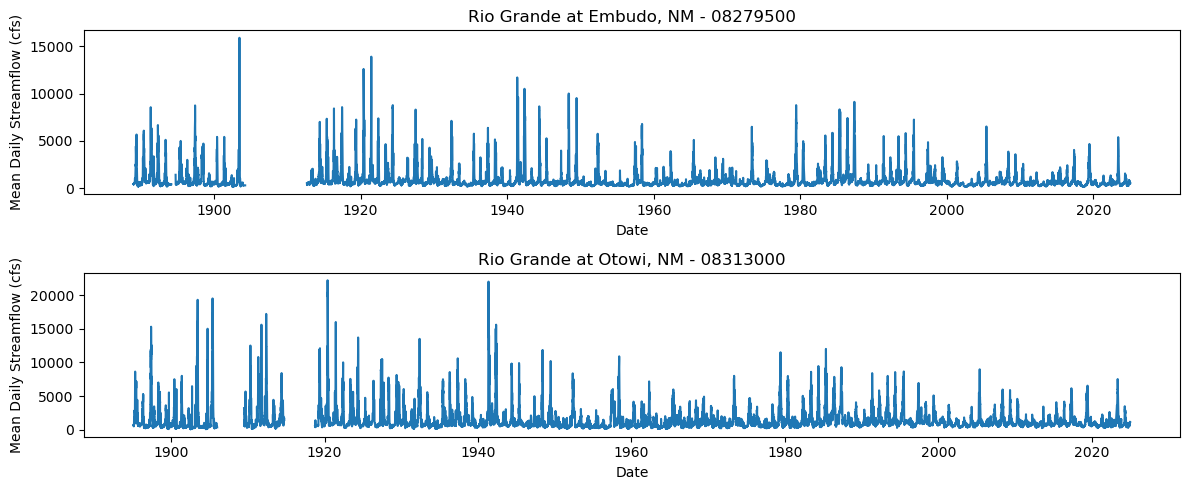

In [11]:
# Assuming df2 is your DataFrame with the renamed columns

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Top subplot: Embudo Streamflow
ax[0].plot(df2.index, df2['Embudo_cfs'], label='Embudo Streamflow (cfs)')
ax[0].set_title('Rio Grande at Embudo, NM - 08279500')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Daily Streamflow (cfs)')
# ax[0].legend()  # Uncomment if you want to show the legend

# Bottom subplot: Otowi Streamflow
ax[1].plot(df2.index, df2['Otowi_cfs'], label='Otowi Streamflow (cfs)')
ax[1].set_title('Rio Grande at Otowi, NM - 08313000')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Mean Daily Streamflow (cfs)')
# ax[1].legend()  # Uncomment if you want to show the legend

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### This Looks Pretty Good, But Let's Ask AI for Help Only Plotting One y-axis Label

##### Prompt

OK.  Now some modifications to the code so it shows `Mean Daily Streamflow (cfs)` only once.  Put it in the middle between the two subplots.  Note that I changed this code snippet:fig, ax = plt.subplots(2, 1, figsize=(12, 5)).  Please keep the new figure size in the code you generate.

##### AI Code

Got it! We’ll add a common y-axis label in the middle of the two subplots.<br>
Also notice I added some code to save the figure as a PNG that can be inserted into a Word document.<br>

Here’s the updated code:

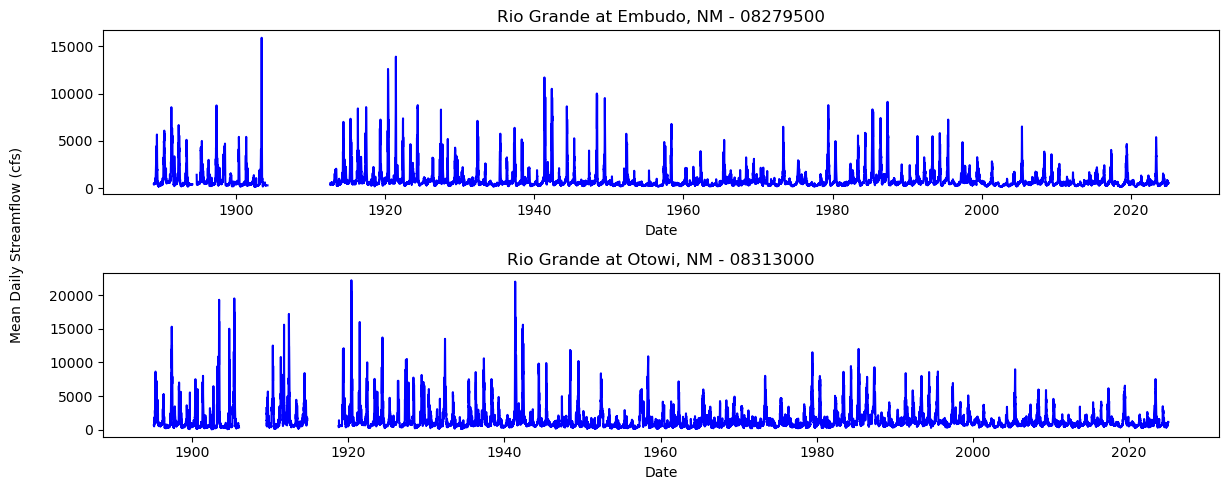

In [12]:
# Assuming df2 is your DataFrame with the renamed columns

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Top subplot: Embudo Streamflow
ax[0].plot(df2.index, df2['Embudo_cfs'], label='Embudo Streamflow (cfs)', color='blue')
ax[0].set_title('Rio Grande at Embudo, NM - 08279500')
ax[0].set_xlabel('Date')

# Bottom subplot: Otowi Streamflow
ax[1].plot(df2.index, df2['Otowi_cfs'], label='Otowi Streamflow (cfs)', color='blue')
ax[1].set_title('Rio Grande at Otowi, NM - 08313000')
ax[1].set_xlabel('Date')

# Common y-axis label
fig.text(-0.02, 0.5, 'Mean Daily Streamflow (cfs)', va='center', rotation='vertical')

# Adjust layout and display the plot
plt.tight_layout()

# Save the figure as a PNG file plt.savefig('streamflow_plot.png', format='png')
# Use bbox_inches='tight' to assure that y-axis label shows up in PNG
plt.savefig('hydrograph_2panel_REV2.png', format='png', bbox_inches='tight')

#### Ask AI a Follow-Up Question

##### Question

What are 0.04 and 0.5?

##### AI Response, Which I Used to Modify Slightly the Code Above

Those numbers are coordinates for placing the y-axis label in the figure.

0.04 is the x-coordinate, meaning it positions the label slightly to the right of the y-axis, just enough to keep it clear from the plots.

0.5 is the y-coordinate, meaning it places the label vertically centered between the two subplots.

This combination ensures the label sits neatly in the middle of your two graphs, giving them a unified look. Makes sense?

**Moral of the Story:** Ask AI for help!<br>


## Step 5. Perform Exploratory Data Analysis

We'll use `ProfileReport` from `ydata-profiling` to understand the data better.

#### Ask AI Again for Help Writing Code

I love this, because if I'm using a package for the first time, I can ask AI for help and get started.  I'd only seen `ydata-profiling` in a YouTube video before preparing this Session, so I find AI is invaluable in getting work done.  As you'll see in my prompt below, often I'll paste some really basic stuff about the package, like how to import it, into the prompt to help give the AI tool context.
<br><br>
**Formal Documentation**

It's also a good idea to look at the Python documentation as you're learning a package.  For example, [here's the documentation for `ydata-profiling`](https://docs.profiling.ydata.ai/latest/) if you're interested.

##### Prompt for AI Tool

Creating the renamed column titles for ‘df2’ worked great.  Now, help me do some EDA on 'df2'. 

I want to use ydata-profiling to create a ProfileReport of 'df2'.

`# Exploratory Data Analysis from ydata_profiling`<br>
`import ProfileReport`<br>
`# ydata-profiling is used for creating detailed reports about the data`

Show me the code to do this and give me an explanation of what it does and what I should expect.


##### Code from AI Tool

It turns out to be simpler than I thought to generate what I saw on the YouTube demonstration, but this saved me the time of looking into the documents of `ydata-profiler`.<br><br>
Of course, if you want to understand things more deeply read the docs!

In [13]:
# Assuming df2 is your DataFrame with the renamed columns
profile = ProfileReport(df2, title='Exploratory Data Analysis of df2', explorative=True)

# To view the report within Jupyter Notebook
profile.to_notebook_iframe()  # this command is using ydata-profiling

# Optionally, still save it to a file
profile.to_file("df2_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### **Adjusting the Profile Report Display Size**

When working with `ydata-profiling` in Jupyter Notebook/Lab, you might notice that the Profile Report appears in a very small window that's difficult to read, as generated by the code above. This happens because of how different versions of the software interact with each other. Let's understand what's happening and how to fix it:

**What's Going On?**
- `ydata-profiling` creates an interactive HTML report of your data
- By default, it tries to display this report directly in your notebook
- Sometimes the default display settings don't work well with your specific setup

**The Solution**<br>
We can solve this by:
1. First saving the report as an HTML file
2. Then displaying that file in a properly sized window in your notebook

In the code below, it displays the HTML file generated by ydata-profiling at 100% of the width of the jupyter notebook cell, which automatically adjusts it if you resize your browser window.  Height is handled a little differently and uses pixels instead of %.  Pixels are used because percent height can be unpredictable and using the number of pixels gives you a predictable result.  You can change the height of the report output by modifying the number of pixels in `height="...px"`.

This approach gives us more control over how the report appears and makes it easier to read and interact with the data analysis.

The code below shows you how to do this:

In [14]:
# First create the profile report
profile = ProfileReport(df2, title='Exploratory Data Analysis of df2', explorative=True)

# Save it to a file
profile.to_file("df2_profile_report.html")

# Display it with custom size using IFrame
display(IFrame("df2_profile_report.html", width="100%", height="500px"))  # You can change the number of pixels (px) to customize the display height

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]